In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from statsmodels.stats.proportion import proportions_ztest
# from statsmodels.stats.proportion import proportions_chisquare
from IPython.display import display, HTML

In [2]:
def two_proprotions_test(success_a, size_a, success_b, size_b):
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

In [3]:
review_test_data = pd.read_csv('/home/tiger/archived-data/aeolus-data/20201206/10/33559659-课程实验-有无复习课_Nov-查询14.csv', encoding = 'gb18030')
# review_test_data.head()

In [4]:
### 预处理数据
#1. 填充空值数据
#2. 增加新字段

review_test_data['d14_duration_cum'] = review_test_data.loc[: , ['d0_duration', 'd1_duration', 'd2_duration', 'd3_duration', 'd4_duration', 'd5_duration', 'd6_duration', 'd7_duration', 'd8_duration','d9_duration', 'd10_duration', 'd11_duration', 'd12_duration', 'd13_duration', 'd14_duration']].astype(float).sum(1)
review_test_data['mile_stone_name'] = review_test_data['mile_stone_name'].fillna('未定级')

review_test_data = review_test_data.rename(columns={"review_study_duration_d14_cum": "review_study_fin_d14_cum"})
review_test_data['review_study_fin_d14_cum'] = review_test_data['review_study_fin_d14_cum'].fillna(0)

review_test_data.loc[(review_test_data['review_study_fin_d14_cum'] > 0), 'd14_cum_review_study'] = 1
review_test_data.loc[(review_test_data['review_study_fin_d14_cum'] == 0), 'd14_cum_review_study'] = 0

# review_test_data.head()


#### 学习留存曲线

In [5]:
def study_curve_data(data, var):
    study_curve = pd.DataFrame(columns = ["user_group", "days", "user_cnt", "study_rate"])
    for group in {'实验组', '对照组'}:
        user_group = group
        group_data = data[data.user_group == group]
        user_cnt = len(group_data)
        for k in range(15):
            var_name = 'd' + str(k) + var
            study_cnt = sum(group_data[var_name])
            study_rate = study_cnt / user_cnt
            study_curve = study_curve.append({"user_group": user_group , "days": k, "user_cnt": user_cnt, "study_rate": study_rate}, ignore_index = True)
    return study_curve

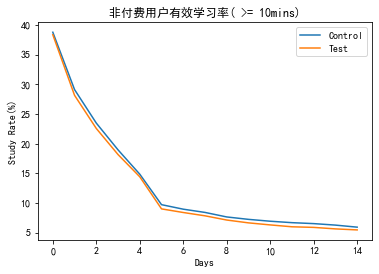

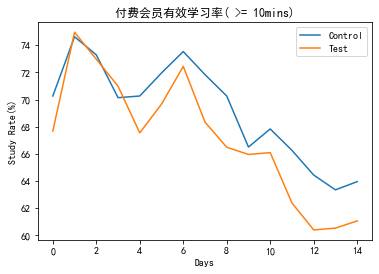

In [409]:
group_list = review_test_data.vip_yn.unique()

for i in range(0,len(group_list)):
    user_group = group_list[i]
    group_data = review_test_data[review_test_data.vip_yn == user_group]
    plot_data = study_curve_data(group_data, '_gt_10m_yn')
    
    vip_ctrl = plot_data[plot_data.user_group == '对照组']
    vip_test = plot_data[plot_data.user_group == '实验组']

    plt.plot(vip_ctrl["days"], vip_ctrl["study_rate"]*100 , label = "Control")
    plt.plot(vip_test["days"], vip_test["study_rate"]*100 , label = "Test")

    plt.xlabel('Days')
    plt.ylabel('Study Rate(%)')

    plt.title(user_group + '有效学习率( >= 10mins)')
    plt.legend()
    plt.show()

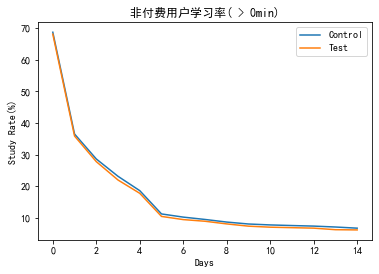

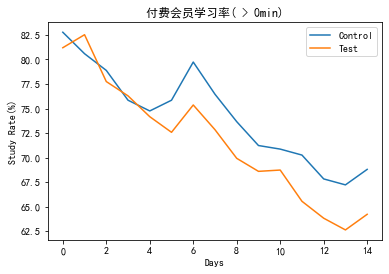

In [410]:
group_list = review_test_data.vip_yn.unique()

for i in range(0,len(group_list)):
    user_group = group_list[i]
    group_data = review_test_data[review_test_data.vip_yn == user_group]
    plot_data = study_curve_data(group_data, '_gt_0_yn')
    
    vip_ctrl = plot_data[plot_data.user_group == '对照组']
    vip_test = plot_data[plot_data.user_group == '实验组']

    plt.plot(vip_ctrl["days"], vip_ctrl["study_rate"]*100 , label = "Control")
    plt.plot(vip_test["days"], vip_test["study_rate"]*100 , label = "Test")

    plt.xlabel('Days')
    plt.ylabel('Study Rate(%)')

    plt.title(user_group + '学习率( > 0min)')
    plt.legend()
    plt.show()

#### 全量用户 

In [342]:
def ab_summary_data(data):
    test_summary = pd.DataFrame(columns = ["User_Group", "Metrics", "Control", "Test", "Delta", "p_value","Significance"])
    
    test_data = data.loc[data.user_group == '实验组']
    ctrl_data = data.loc[data.user_group == '对照组']

    dnu_t = len(test_data)
    dnu_c = len(ctrl_data)

    # 新增用户
    test_summary = test_summary.append({"Metrics": '总新增用户', "Control": '{:,}'.format(dnu_c), "Test": '{:,}'.format(dnu_t), "Delta": '-', "p_value": '-', "Significance": '-'}, ignore_index = True)
    
    # 复习课渗透
    d14_review_user_c = sum(ctrl_data.d14_cum_review_study)
    d14_review_user_ratio_c = round(d14_review_user_c / dnu_c, 4)
    test_summary = test_summary.append({"Metrics": 'd14累计复习课渗透率', "Control": "{:.2%}".format(d14_review_user_ratio_c), "Test": '-', "Delta": '-', "p_value": '-',"Significance": '-'}, ignore_index = True)

    d14_review_cnt = sum(ctrl_data.review_study_fin_d14_cum)
    d14_avg_review_cnt_c = round(d14_review_cnt / d14_review_user_c, 2) 
    test_summary = test_summary.append({"Metrics": 'd14累计人均复习课完课数', "Control":  str(round(d14_avg_review_cnt_c,2)), "Test": '-', "Delta": '-', "p_value": '-', "Significance": '-'}, ignore_index = True)

        
    # d6转化
    vip_t = len(test_data.loc[test_data.vip_yn == '付费会员'])
    vip_c = len(ctrl_data.loc[ctrl_data.vip_yn == '付费会员'])
    d6_cr_t = round(vip_t / dnu_t, 4)
    d6_cr_c = round(vip_c / dnu_c, 4)
    d6_cr_delta = d6_cr_t / d6_cr_c - 1 if d6_cr_c > 0 else np.nan
    d6_cr_p_value = two_proprotions_test(vip_t, dnu_t, vip_c, dnu_c)[1]
    d6_cr_sig =  "Significant" if d6_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": 'd6转化率', "Control": "{:.2%}".format(d6_cr_c), "Test": "{:.2%}".format(d6_cr_t), "Delta": "{:.2%}".format(d6_cr_delta), "p_value": round(d6_p_value, 4), "Significance": d6_cr_sig}, ignore_index = True)

    # d14学习率(>0)
    d14_study_t = sum(test_data.d14_gt_0_yn)
    d14_study_c = sum(ctrl_data.d14_gt_0_yn)
    d14_st_rate_t = round(d14_study_t / dnu_t, 4)
    d14_st_rate_c = round(d14_study_c / dnu_c, 4)
    d14_st_rate_delta = d14_st_rate_t / d14_st_rate_c - 1 if d14_st_rate_c >0 else np.nan
    d14_st_rate_p_value = two_proprotions_test(d14_study_t, dnu_t, d14_study_c, dnu_c)[1]
    d14_st_rate_sig =  "Significant" if d14_st_rate_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": 'd14学习率(>0)', "Control": "{:.2%}".format(d14_st_rate_c), "Test": "{:.2%}".format(d14_st_rate_t), "Delta": "{:.2%}".format(d14_st_rate_delta), "p_value": round(d14_st_rate_p_value, 4), "Significance": d14_st_rate_sig}, ignore_index = True)

    # d14学习率(>=10m)
    d14_study_10m_t = sum(test_data.d14_gt_10m_yn)
    d14_study_10m_c = sum(ctrl_data.d14_gt_10m_yn)
    d14_st_10m_rate_t = round(d14_study_10m_t / dnu_t, 4)
    d14_st_10m_rate_c = round(d14_study_10m_c / dnu_c, 4)
    d14_st_10m_rate_delta = d14_st_10m_rate_t / d14_st_10m_rate_c - 1 if d14_st_10m_rate_c > 0 else np.nan
    d14_st_10m_rate_p_value = two_proprotions_test(d14_study_10m_t, dnu_t, d14_study_10m_c, dnu_c)[1]
    d14_st_10m_rate_sig =  "Significant" if d14_st_10m_rate_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": 'd14学习率(>10m)', "Control": "{:.2%}".format(d14_st_10m_rate_c), "Test": "{:.2%}".format(d14_st_10m_rate_t), "Delta": "{:.2%}".format(d14_st_10m_rate_delta), "p_value": round(d14_st_10m_rate_p_value, 4), "Significance": d14_st_10m_rate_sig}, ignore_index = True)

    # 前14人均日学习时长: 分钟
    d14_study_cum_t = sum(test_data.d14_duration_cum)
    d14_study_cum_c = sum(ctrl_data.d14_duration_cum)
    d14_avg_daily_st_t = round(d14_study_cum_t / dnu_t / 60 / 15, 2)
    d14_avg_daily_st_c = round(d14_study_cum_c / dnu_c / 60 / 15, 2)
    d14_avg_daily_st_delta = d14_avg_daily_st_t / d14_avg_daily_st_c - 1 if d14_avg_daily_st_c > 0 else np.nan
    d14_avg_daily_st_p_value = stats.ttest_ind(test_data.d14_duration_cum, ctrl_data.d14_duration_cum, equal_var = False).pvalue
    d14_avg_daily_st_sig =  "Significant" if d14_avg_daily_st_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": '前14人均日学习时长: 分钟', "Control": str(round(d14_avg_daily_st_c,2)), "Test": str(round(d14_avg_daily_st_t,2)), "Delta": "{:.2%}".format(d14_avg_daily_st_delta), "p_value": round(d14_avg_daily_st_p_value, 4), "Significance": d14_avg_daily_st_sig}, ignore_index = True)

    test_summary['User_Group'] = '全量用户'
    
    return test_summary

In [343]:
output = ab_summary_data(review_test_data)
output.style.apply(lambda x: ["background: green" if v == 'Significant' else "" for v in x], axis = 1).hide_index()

User_Group,Metrics,Control,Test,Delta,p_value,Significance
全量用户,总新增用户,"20,245","20,455",-,-,-
全量用户,d14累计复习课渗透率,22.07%,-,-,-,-
全量用户,d14累计人均复习课完课数,5.85,-,-,-,-
全量用户,d6转化率,4.07%,3.69%,-9.34%,0.047700,Significant
全量用户,d14学习率(>0),9.26%,8.33%,-10.04%,0.000900,Significant
全量用户,d14学习率(>10m),8.31%,7.54%,-9.27%,0.003800,Significant
全量用户,前14人均日学习时长: 分钟,5.42,4.95,-8.67%,0.000000,Significant


#### 付费与否

In [344]:
def ab_summary_data_vip(data):
    test_summary = pd.DataFrame(columns = ["User_Group", "Metrics", "Control", "Test", "Delta", "p_value", "Significance"])

    test_data = data.loc[data.user_group == '实验组']
    ctrl_data = data.loc[data.user_group == '对照组']

    dnu_t = len(test_data)
    dnu_c = len(ctrl_data)

    # 新增用户
    test_summary = test_summary.append({"Metrics": '总新增用户', "Control": '{:,}'.format(dnu_c), "Test": '{:,}'.format(dnu_t), "Delta": '-', "p_value": '-', "Significance": '-'}, ignore_index = True)
   
    # 复习课渗透
    d14_review_user_c = sum(ctrl_data.d14_cum_review_study)
    d14_review_user_ratio_c = round(d14_review_user_c / dnu_c, 4)
    test_summary = test_summary.append({"Metrics": 'd14累计复习课渗透率', "Control": "{:.2%}".format(d14_review_user_ratio_c), "Test": '-', "Delta": '-', "p_value": '-', "Significance": '-'}, ignore_index = True)

    d14_review_cnt = sum(ctrl_data.review_study_fin_d14_cum)
    d14_avg_review_cnt_c = round(d14_review_cnt / d14_review_user_c, 2) 
    test_summary = test_summary.append({"Metrics": 'd14累计人均复习课完课数', "Control":  str(round(d14_avg_review_cnt_c,2)), "Test": '-', "Delta": '-', "p_value": '-', "Significance": '-'}, ignore_index = True)

    # d14学习率(>0)
    d14_study_t = sum(test_data.d14_gt_0_yn)
    d14_study_c = sum(ctrl_data.d14_gt_0_yn)
    d14_st_rate_t = round(d14_study_t / dnu_t, 4)
    d14_st_rate_c = round(d14_study_c / dnu_c, 4)
    d14_st_rate_delta = d14_st_rate_t / d14_st_rate_c - 1 if d14_st_rate_c >0 else np.nan
    d14_st_rate_p_value = two_proprotions_test(d14_study_t, dnu_t, d14_study_c, dnu_c)[1]
    d14_st_rate_sig =  "Significant" if d14_st_rate_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": 'd14学习率(>0)', "Control": "{:.2%}".format(d14_st_rate_c), "Test": "{:.2%}".format(d14_st_rate_t), "Delta": "{:.2%}".format(d14_st_rate_delta), "p_value": round(d14_st_rate_p_value, 4) , "Significance": d14_st_rate_sig}, ignore_index = True)

    # d14学习率(>=10m)
    d14_study_10m_t = sum(test_data.d14_gt_10m_yn)
    d14_study_10m_c = sum(ctrl_data.d14_gt_10m_yn)
    d14_st_10m_rate_t = round(d14_study_10m_t / dnu_t, 4)
    d14_st_10m_rate_c = round(d14_study_10m_c / dnu_c, 4)
    d14_st_10m_rate_delta = d14_st_10m_rate_t / d14_st_10m_rate_c - 1 if d14_st_10m_rate_c > 0 else np.nan
    d14_st_10m_rate_p_value = two_proprotions_test(d14_study_10m_t, dnu_t, d14_study_10m_c, dnu_c)[1]
    d14_st_10m_rate_sig =  "Significant" if d14_st_10m_rate_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": 'd14学习率(>10m)', "Control": "{:.2%}".format(d14_st_10m_rate_c), "Test": "{:.2%}".format(d14_st_10m_rate_t), "Delta": "{:.2%}".format(d14_st_10m_rate_delta), "p_value": round(d14_st_10m_rate_p_value, 4), "Significance": d14_st_10m_rate_sig}, ignore_index = True)

    # 前14人均日学习时长: 分钟
    d14_study_cum_t = sum(test_data.d14_duration_cum)
    d14_study_cum_c = sum(ctrl_data.d14_duration_cum)
    d14_avg_daily_st_t = round(d14_study_cum_t / dnu_t / 60 / 15, 2)
    d14_avg_daily_st_c = round(d14_study_cum_c / dnu_c / 60 / 15, 2)
    d14_avg_daily_st_delta = d14_avg_daily_st_t / d14_avg_daily_st_c - 1 if d14_avg_daily_st_c > 0 else np.nan
    d14_avg_daily_st_p_value = stats.ttest_ind(test_data.d14_duration_cum, ctrl_data.d14_duration_cum, equal_var = False).pvalue
    d14_avg_daily_st_sig =  "Significant" if d14_avg_daily_st_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": '前14人均日学习时长: 分钟', "Control": str(round(d14_avg_daily_st_c,2)), "Test": str(round(d14_avg_daily_st_t,2)), "Delta": "{:.2%}".format(d14_avg_daily_st_delta), "p_value": round(d14_avg_daily_st_p_value, 4), "Significance": d14_avg_daily_st_sig}, ignore_index = True)

    test_summary['User_Group'] = group_list[i]
    
    return test_summary

In [339]:
group_list = review_test_data.vip_yn.unique()
output = pd.DataFrame(columns = ["User_Group", "Metrics", "Control", "Test", "Delta", "p_value", "Significance"])

for i in range(0,len(group_list)):
    user_group = group_list[i]
    group_data = review_test_data[review_test_data.vip_yn == user_group]
    output = output.append(ab_summary_data_vip(group_data))

output.reset_index(drop=True).style.apply(lambda x: ["background: green" if v == 'Significant' else "" for v in x], axis = 1).hide_index()

User_Group,Metrics,Control,Test,Delta,p_value,Significance
非付费用户,总新增用户,"19,421","19,700",-,-,-
非付费用户,d14累计复习课渗透率,19.26%,-,-,-,-
非付费用户,d14累计人均复习课完课数,5.28,-,-,-,-
非付费用户,d14学习率(>0),6.73%,6.18%,-8.17%,0.026300,Significant
非付费用户,d14学习率(>10m),5.95%,5.49%,-7.73%,0.047600,Significant
非付费用户,前14人均日学习时长: 分钟,4.56,4.23,-7.24%,0.001100,Significant
付费会员,总新增用户,824,755,-,-,-
付费会员,d14累计复习课渗透率,88.47%,-,-,-,-
付费会员,d14累计人均复习课完课数,8.76,-,-,-,-
付费会员,d14学习率(>0),68.81%,64.24%,-6.64%,0.054300,Significant


#### 等级

In [346]:
def ab_summary_data_group(data):
    test_summary = pd.DataFrame(columns = ["User_Group", "Metrics", "Control", "Test", "Delta", "p_value","Significance"])
    
    test_data = data.loc[data.user_group == '实验组']
    ctrl_data = data.loc[data.user_group == '对照组']

    dnu_t = len(test_data)
    dnu_c = len(ctrl_data)

    # 新增用户
    test_summary = test_summary.append({"Metrics": '总新增用户', "Control": '{:,}'.format(dnu_c), "Test": '{:,}'.format(dnu_t), "Delta": '-', "p_value": '-', "Significance": '-'}, ignore_index = True)
    
    # 复习课渗透
    d14_review_user_c = sum(ctrl_data.d14_cum_review_study)
    d14_review_user_ratio_c = round(d14_review_user_c / dnu_c, 4)
    test_summary = test_summary.append({"Metrics": 'd14累计复习课渗透率', "Control": "{:.2%}".format(d14_review_user_ratio_c), "Test": '-', "Delta": '-', "p_value": '-',"Significance": '-'}, ignore_index = True)

    d14_review_cnt = sum(ctrl_data.review_study_fin_d14_cum)
    d14_avg_review_cnt_c = round(d14_review_cnt / d14_review_user_c, 2) 
    test_summary = test_summary.append({"Metrics": 'd14累计人均复习课完课数', "Control":  str(round(d14_avg_review_cnt_c,2)), "Test": '-', "Delta": '-', "p_value": '-', "Significance": '-'}, ignore_index = True)

        
    # d6转化
    vip_t = len(test_data.loc[test_data.vip_yn == '付费会员'])
    vip_c = len(ctrl_data.loc[ctrl_data.vip_yn == '付费会员'])
    d6_cr_t = round(vip_t / dnu_t, 4)
    d6_cr_c = round(vip_c / dnu_c, 4)
    d6_cr_delta = d6_cr_t / d6_cr_c - 1 if d6_cr_c > 0 else np.nan
    d6_cr_p_value = two_proprotions_test(vip_t, dnu_t, vip_c, dnu_c)[1]
    d6_cr_sig =  "Significant" if d6_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": 'd6转化率', "Control": "{:.2%}".format(d6_cr_c), "Test": "{:.2%}".format(d6_cr_t), "Delta": "{:.2%}".format(d6_cr_delta), "p_value": round(d6_p_value, 4), "Significance": d6_cr_sig}, ignore_index = True)

    # d14学习率(>0)
    d14_study_t = sum(test_data.d14_gt_0_yn)
    d14_study_c = sum(ctrl_data.d14_gt_0_yn)
    d14_st_rate_t = round(d14_study_t / dnu_t, 4)
    d14_st_rate_c = round(d14_study_c / dnu_c, 4)
    d14_st_rate_delta = d14_st_rate_t / d14_st_rate_c - 1 if d14_st_rate_c >0 else np.nan
    d14_st_rate_p_value = two_proprotions_test(d14_study_t, dnu_t, d14_study_c, dnu_c)[1]
    d14_st_rate_sig =  "Significant" if d14_st_rate_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": 'd14学习率(>0)', "Control": "{:.2%}".format(d14_st_rate_c), "Test": "{:.2%}".format(d14_st_rate_t), "Delta": "{:.2%}".format(d14_st_rate_delta), "p_value": round(d14_st_rate_p_value, 4), "Significance": d14_st_rate_sig}, ignore_index = True)

    # d14学习率(>=10m)
    d14_study_10m_t = sum(test_data.d14_gt_10m_yn)
    d14_study_10m_c = sum(ctrl_data.d14_gt_10m_yn)
    d14_st_10m_rate_t = round(d14_study_10m_t / dnu_t, 4)
    d14_st_10m_rate_c = round(d14_study_10m_c / dnu_c, 4)
    d14_st_10m_rate_delta = d14_st_10m_rate_t / d14_st_10m_rate_c - 1 if d14_st_10m_rate_c > 0 else np.nan
    d14_st_10m_rate_p_value = two_proprotions_test(d14_study_10m_t, dnu_t, d14_study_10m_c, dnu_c)[1]
    d14_st_10m_rate_sig =  "Significant" if d14_st_10m_rate_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": 'd14学习率(>10m)', "Control": "{:.2%}".format(d14_st_10m_rate_c), "Test": "{:.2%}".format(d14_st_10m_rate_t), "Delta": "{:.2%}".format(d14_st_10m_rate_delta), "p_value": round(d14_st_10m_rate_p_value, 4), "Significance": d14_st_10m_rate_sig}, ignore_index = True)

    # 前14人均日学习时长: 分钟
    d14_study_cum_t = sum(test_data.d14_duration_cum)
    d14_study_cum_c = sum(ctrl_data.d14_duration_cum)
    d14_avg_daily_st_t = round(d14_study_cum_t / dnu_t / 60 / 15, 2)
    d14_avg_daily_st_c = round(d14_study_cum_c / dnu_c / 60 / 15, 2)
    d14_avg_daily_st_delta = d14_avg_daily_st_t / d14_avg_daily_st_c - 1 if d14_avg_daily_st_c > 0 else np.nan
    d14_avg_daily_st_p_value = stats.ttest_ind(test_data.d14_duration_cum, ctrl_data.d14_duration_cum, equal_var = False).pvalue
    d14_avg_daily_st_sig =  "Significant" if d14_avg_daily_st_p_value < 0.1 else "Non-significant"
    test_summary = test_summary.append({"Metrics": '前14人均日学习时长: 分钟', "Control": str(round(d14_avg_daily_st_c,2)), "Test": str(round(d14_avg_daily_st_t,2)), "Delta": "{:.2%}".format(d14_avg_daily_st_delta), "p_value": round(d14_avg_daily_st_p_value, 4), "Significance": d14_avg_daily_st_sig}, ignore_index = True)

    test_summary['User_Group'] = user_group
    
    return test_summary

In [347]:
group_list = ['A1初', 'A1中', 'A1高', 'A2初', 'A2中', 'A2高', 'B1初', 'B1中', 'B1高', '未定级']
output = pd.DataFrame(columns = ["User_Group", "Metrics", "Control", "Test", "Delta", "p_value","Significance"])

for i in range(0,len(group_list)):
    user_group = group_list[i]
    group_data = review_test_data[review_test_data.mile_stone_name == user_group]
    output = output.append(ab_summary_data_group(group_data))

output.reset_index(drop=True).style.apply(lambda x: ["background: green" if v == 'Significant' else "" for v in x], axis = 1).hide_index()

User_Group,Metrics,Control,Test,Delta,p_value,Significance
A1初,总新增用户,"6,534","6,662",-,-,-
A1初,d14累计复习课渗透率,10.88%,-,-,-,-
A1初,d14累计人均复习课完课数,5.05,-,-,-,-
A1初,d6转化率,2.36%,2.01%,-14.83%,0.047700,Significant
A1初,d14学习率(>0),4.62%,3.69%,-20.13%,0.007500,Significant
A1初,d14学习率(>10m),4.07%,3.24%,-20.39%,0.011200,Significant
A1初,前14人均日学习时长: 分钟,3.46,3.01,-13.01%,0.000600,Significant
A1中,总新增用户,"5,351","5,386",-,-,-
A1中,d14累计复习课渗透率,14.15%,-,-,-,-
A1中,d14累计人均复习课完课数,4.91,-,-,-,-
